This notebook outlines a specialized **data preparation and transformation** process for creating a "**grain-free**" dataset from mycetoma histopathology images.
The method uses the segmentation mask to define the exact location of the mycetoma grain. It then systematically splits the image into patches, discarding any patch that intersects with the mask. This results in a dataset composed entirely of **Non-ROI Patches** (patches without grain presence).


In [1]:
#Rename images in different folder
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

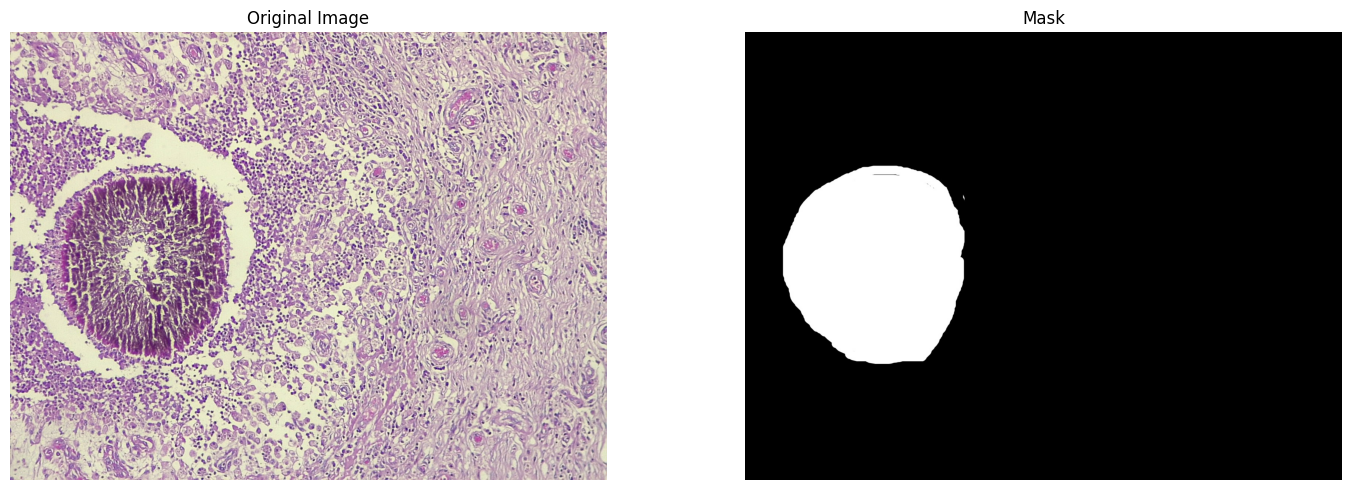

In [3]:
image = '/content/drive/MyDrive/segmentation-dataset-jpg-image-mask/images/falciformisporasenegalensis/23HF2248_7.jpg'
mask = '/content/drive/MyDrive/segmentation-dataset-jpg-image-mask/mask/falciformisporasenegalensis/23HF2248_7.jpg'

# Load the images
original_image = cv2.imread(image)
original_image_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
mask_image = cv2.imread(mask, cv2.IMREAD_GRAYSCALE)

# Plot side by side
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Original image
axes[0].imshow(original_image_rgb)
axes[0].set_title('Original Image')
axes[0].axis('off')

# Mask
axes[1].imshow(mask_image, cmap='gray')
axes[1].set_title('Mask')
axes[1].axis('off')

plt.tight_layout()
plt.show()

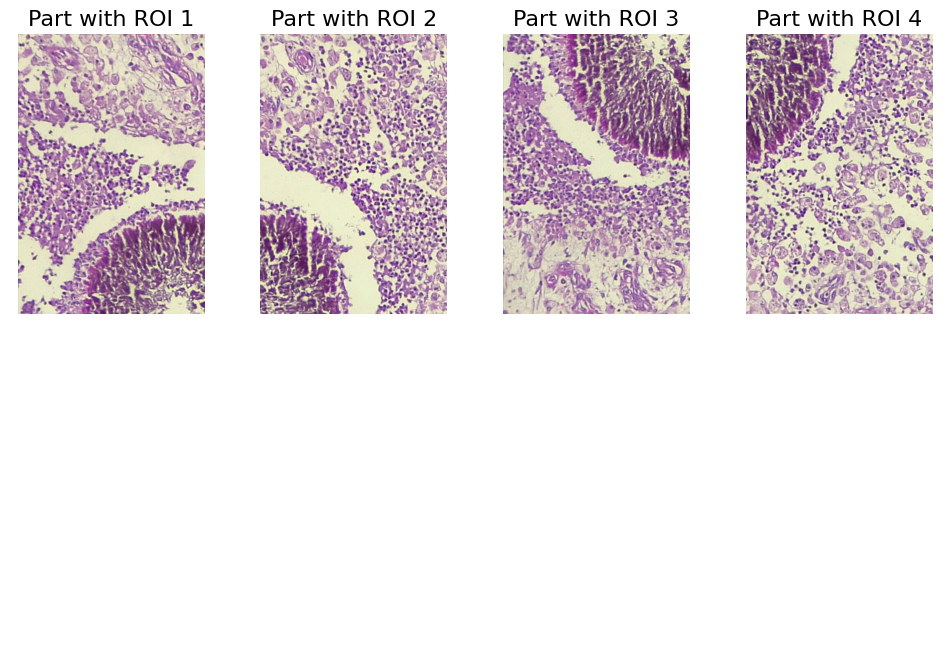

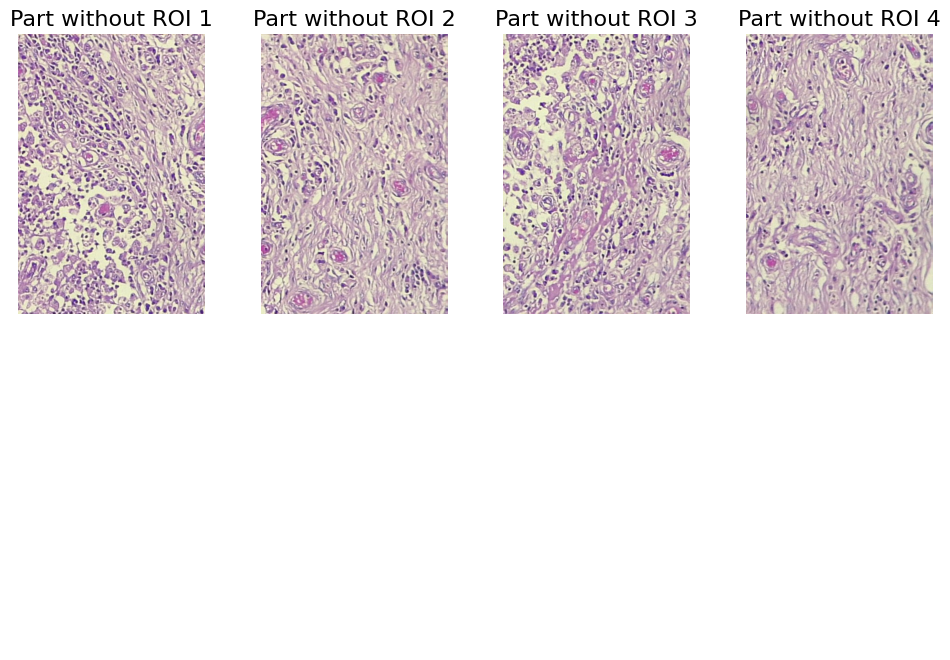

In [4]:
def split_image(image, n_parts=8):
    """
    Split the image into n_parts, in this case, 8 parts.
    Assumes the image can be divided evenly.
    """
    h, w, _ = image.shape
    # Calculate the size of each split part
    part_height = h // 2
    part_width = w // 4

    splits = []
    for i in range(2):  # Split the image in 2 parts vertically
        for j in range(4):  # Split the image in 4 parts horizontally
            y_start = i * part_height
            y_end = y_start + part_height
            x_start = j * part_width
            x_end = x_start + part_width

            # Extract the image part and append it to the splits list
            part = image[y_start:y_end, x_start:x_end]
            splits.append((part, (y_start, y_end, x_start, x_end)))
    return splits

def contains_roi(part, mask):
    """
    Check if the split part contains any ROI from the mask.
    The mask is assumed to be binary: 1 for ROI, 0 for background.
    """
    # Get the bounding box of the mask's ROI
    roi_mask = mask > 0  # Assuming ROI is represented by non-zero values in the mask
    return np.any(part[roi_mask])

def main():
    # Load the original image and the mask image
    original_image = cv2.imread(image)
    mask_image = cv2.imread(mask, cv2.IMREAD_GRAYSCALE)

    # Split the image into 8 parts
    splits = split_image(original_image)

    # Lists to store parts with and without ROI
    roi_parts = []
    non_roi_parts = []

    # Iterate through the splits and verify if they contain ROI
    for part, coords in splits:
        y_start, y_end, x_start, x_end = coords
        if contains_roi(part, mask_image[y_start:y_end, x_start:x_end]):
            roi_parts.append(part)  # Add to ROI parts list
        else:
            non_roi_parts.append(part)  # Add to non-ROI parts list

    # Display the parts with ROI
    fig, axes = plt.subplots(2, 4, figsize=(12, 8))
    for i, ax in enumerate(axes.flat):
        if i < len(roi_parts):
            ax.imshow(cv2.cvtColor(roi_parts[i], cv2.COLOR_BGR2RGB))
            ax.set_title(f"Part with ROI {i+1}" , fontsize=16)
        ax.axis('off')
    plt.show()

    # Display the parts without ROI
    fig, axes = plt.subplots(2, 4, figsize=(12, 8))
    for i, ax in enumerate(axes.flat):
        if i < len(non_roi_parts):
            ax.imshow(cv2.cvtColor(non_roi_parts[i], cv2.COLOR_BGR2RGB))
            ax.set_title(f"Part without ROI {i+1}" , fontsize=16)
        ax.axis('off')
    plt.show()

if __name__ == "__main__":
    main()
